In [1]:
import torch
from torch import nn
from PIL import Image
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import Dataset, random_split, DataLoader
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
class SubWayNet(nn.Module):

    def __init__(self):

        # (472, 988)
        super(SubWayNet,self).__init__()
        # self.conv1 =  
        # self.conv2 =  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        # self.conv3 =  nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        # self.conv4 =  nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)

        self.sequential1 =  nn.Sequential(
            nn.Conv2d(in_channels=3,stride=3, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.sequential2 =  nn.Sequential(
            nn.Conv2d(in_channels=64, stride=3, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
        )

        # self.sequential3 =  nn.Sequential(
        #             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        #             nn.BatchNorm2d(128),
        #             nn.ReLU(),
        #             nn.MaxPool2d(kernel_size=2),
        #             nn.Dropout(p=0.5)
        # )

    
        # THIS ASSUMES THAT THE SEQUENTIAL IS 500
        self.fc_layers =  nn.Sequential(
                nn.Linear(128*13*13,64),
                nn.ReLU(),
                
                nn.Linear(64,5)
        )
        nn.Dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self,x):

        x =  self.sequential1(x)
        x =  self.sequential2(x)
        # x =  self.sequential3(x)
        # x = x.view(x.size(0),-1)
        x= x.view(-1,128*13*13)

        x  =self.dropout(x)

        x =  self.fc_layers(x)
        return x

In [3]:
transform  =transforms.Compose([
    transforms.Resize((500,500)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [4]:
class LoadImages(Dataset):

    def __init__(self, csv_file='new_csv.csv', transform=None):
        self.root_dir =  "SHOTS" 
        self.re_map = {'a':"left", "w":"jump","s":"roll","d":"right",'blank':'None'}
        
        self.df=  pd.read_csv(csv_file,dtype={'image':int, 'keyPress':str})
        
        self.df['keyPress'] = self.df["keyPress"].apply(self.cleaner)
        self.df = self.df[self.df.image.apply(self.exists)]      
        self.df["keyPress"] = self.df["keyPress"].apply(lambda x: self.re_map.get(x))
        
        self.one_hot_encoded_df = pd.get_dummies(self.df['keyPress'], dtype=float)
        self.df = pd.concat([self.df, self.one_hot_encoded_df], axis=1)

        self.transform = transform
    
    
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        pt =  os.path.join(self.root_dir,str(self.df.iloc[idx][0])+".jpg")
        img = Image.open(pt)

        y_label =  self.df.drop(columns=['image','keyPress']).iloc[idx]
        
        
        
        if self.transform:
            img =  transform(img)

        # return img, torch.tensor(y_label).view(-1)
        return img, torch.tensor(y_label)
        
    def getMappings(self):
        return dict(enumerate(self.df['keyPress'].astype('category').cat.categories))

    def cleaner(self,x):
        if 'blank' not in x:
            
            return  x[0]
        else:
            return 'blank'
            
            
    def exists(self,filename:str):
        if os.path.exists(f"SHOTS/{filename}.jpg"):
            return True
        else:
        
            return False

In [5]:
# load the dataset
custom_data =  LoadImages(transform=transform)

In [6]:
custom_data.getMappings()

{0: 'None', 1: 'jump', 2: 'left', 3: 'right', 4: 'roll'}

In [7]:
# custom_data[50000][1].to('cpu').numpy()

In [8]:
# split into train and test  and validation set
train_size = int(0.85*len(custom_data))
val_size=  len(custom_data) - train_size
train_dataset  , val_dataset =  torch.utils.data.random_split(custom_data,[train_size,val_size])

In [9]:
train_size, val_size

(71616, 12639)

In [10]:
# create data loaders
batch_size=32
train_loader =  DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=batch_size)

In [11]:
for i,x in train_loader:
    break

In [12]:
# LOAD MODEL
model =  SubWayNet()

# Define the loss function and optimizer
criterion =  nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(model.parameters(),lr=0.001)

In [13]:
custom_data.getMappings()

{0: 'None', 1: 'jump', 2: 'left', 3: 'right', 4: 'roll'}

In [14]:
num_epochs =6
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


SubWayNet(
  (sequential1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequential2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=21632, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [15]:
# summary(model,(3,500,500))

In [16]:
summary(model,input_size=(3,500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 166, 166]           1,792
       BatchNorm2d-2         [-1, 64, 166, 166]             128
              ReLU-3         [-1, 64, 166, 166]               0
         MaxPool2d-4           [-1, 64, 83, 83]               0
            Conv2d-5          [-1, 128, 27, 27]          73,856
       BatchNorm2d-6          [-1, 128, 27, 27]             256
              ReLU-7          [-1, 128, 27, 27]               0
         MaxPool2d-8          [-1, 128, 13, 13]               0
           Dropout-9                [-1, 21632]               0
           Linear-10                   [-1, 64]       1,384,512
             ReLU-11                   [-1, 64]               0
           Linear-12                    [-1, 5]             325
Total params: 1,460,869
Trainable params: 1,460,869
Non-trainable params: 0
---------------------------

In [17]:
for epoch in range(num_epochs):
    model.train()
    losses=[]
    train_loss = 0.0
    running_loss = 0.0
    correct=0
    total=0
    for train_idx,(images , labels) in enumerate(train_loader):
        images,labels  = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits =  model(images)
        loss =  criterion(logits,labels)
        loss.backward()
        optimizer.step()
        train_loss +=loss.item() * images.size(0)
        losses.append(loss.item())

        
        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()
        
        if train_idx % 640==0:
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    if epoch>0 and epoch %2==0:
        
        print("Entering Model Eval")
        model.eval()
        val_loss = 0.0
        val_corrects =0
        with torch.no_grad():
            for images, labels in val_loader:
                images,labels  = images.to(device), labels.to(device)
                logits  = model(images)
                loss =  criterion(logits,labels)
                val_loss += loss.item() * images.size(0)
                _, preds =  torch.max(logits,1)

                val_corrects += torch.sum(preds ==labels.argmax(dim=1))

        train_loss =  train_loss / len(train_loader.dataset)
        val_loss =  val_loss /len(val_loader.dataset)
        val_accuracy =  val_corrects.double()/len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, val Loss: {val_loss:.4f}, val Accuracy: {val_accuracy} ")
            
torch.save(model,"finalTrial_complete_data.pt") 
        

Epoch 1/6, Loss: 0.0000, Accuracy: 0.1250
Epoch 1/6, Loss: 0.0104, Accuracy: 0.5414
Epoch 1/6, Loss: 0.0186, Accuracy: 0.6018
Epoch 1/6, Loss: 0.0257, Accuracy: 0.6414
Epoch 2/6, Loss: 0.0000, Accuracy: 0.5938
Epoch 2/6, Loss: 0.0060, Accuracy: 0.7634
Epoch 2/6, Loss: 0.0118, Accuracy: 0.7714
Epoch 2/6, Loss: 0.0173, Accuracy: 0.7772
Epoch 3/6, Loss: 0.0000, Accuracy: 0.9062
Epoch 3/6, Loss: 0.0050, Accuracy: 0.8081
Epoch 3/6, Loss: 0.0099, Accuracy: 0.8115
Epoch 3/6, Loss: 0.0146, Accuracy: 0.8133
Entering Model Eval
Epoch 3/6, Train Loss: 0.5440, val Loss: 0.4947, val Accuracy: 0.8287839227787008 
Epoch 4/6, Loss: 0.0000, Accuracy: 0.8125
Epoch 4/6, Loss: 0.0044, Accuracy: 0.8286
Epoch 4/6, Loss: 0.0088, Accuracy: 0.8291
Epoch 4/6, Loss: 0.0131, Accuracy: 0.8303
Epoch 5/6, Loss: 0.0000, Accuracy: 0.9688
Epoch 5/6, Loss: 0.0040, Accuracy: 0.8436
Epoch 5/6, Loss: 0.0082, Accuracy: 0.8421
Epoch 5/6, Loss: 0.0121, Accuracy: 0.8436
Entering Model Eval
Epoch 5/6, Train Loss: 0.4539, val Lo

In [18]:
# epoch_loss = running_loss / len(train_loader.dataset)
# epoch_loss
epoch_loss = running_loss / len(train_loader.dataset)
epoch_accuracy = correct / total
print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
 

Epoch 6/6, Loss: 0.0133, Accuracy: 0.8537


In [19]:
print("Entering Model Eval")
model.eval()
val_loss = 0.0
val_corrects =0
with torch.no_grad():
    for images, labels in val_loader:
        images,labels  = images.to(device), labels.to(device)
        logits  = model(images)
        loss =  criterion(logits,labels)
        val_loss += loss.item() * images.size(0)
        _, preds =  torch.max(logits,1)

        val_corrects += torch.sum(preds ==labels.argmax(dim=1))

    train_loss =  train_loss / len(train_loader.dataset)
    val_loss =  val_loss /len(val_loader.dataset)
    val_accuracy =  val_corrects.double()/len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, val Loss: {val_loss:.4f}, val Accuracy: {val_accuracy} ")
            
torch.save(model,"finalTrial_complete_data.pt") 

Entering Model Eval


Epoch 6/6, Train Loss: 0.4263, val Loss: 0.3973, val Accuracy: 0.8644671255637313 


In [20]:
epoch_loss = running_loss / len(train_loader)
epoch_accuracy = correct / total

print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch 6/6, Loss: 0.4263, Accuracy: 0.8537


In [21]:
torch.save(model,"model_10_epochs87_73.pt")

In [22]:
# labels.view(-1).shape

In [23]:
conv2 = nn.Conv2d(in_channels=3,
                  out_channels=64,
                  kernel_size=3,
                  padding=1,stride=3)

x = torch.randn(32, 3, 500, 500)
y = conv2(x)
y.shape

torch.Size([32, 64, 167, 167])

In [24]:
# preds

In [25]:
# labels.view(-1)

In [26]:
# labels.argmax(dim=1).shape

In [27]:
len(losses)

2238

In [28]:
len(train_loader)

2238

In [29]:
images.shape

torch.Size([31, 3, 500, 500])

In [30]:
542/2


271.0

In [31]:
542 %271

0

In [32]:
import matplotlib.pyplot as plt

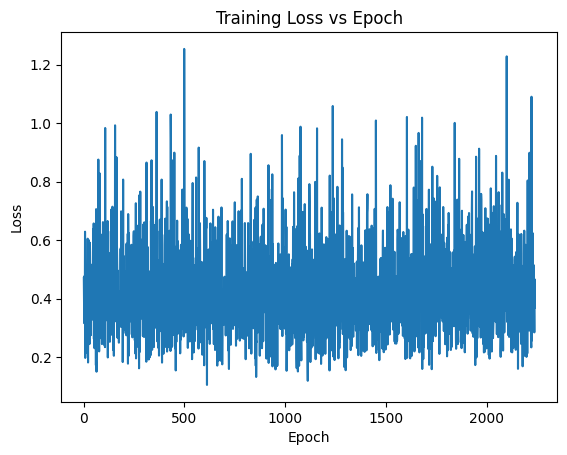

In [33]:
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
# plt.grid(True)
plt.show()

In [34]:
# plt.plot(range(1, len(losses) + 1), losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss vs Epoch')
# # plt.grid(True)
# plt.show()

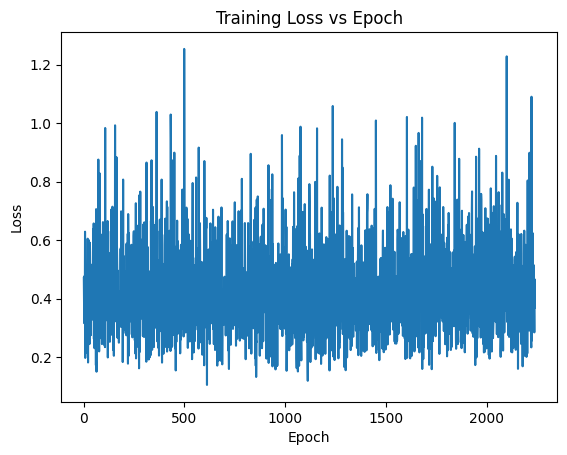

In [35]:
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
# plt.grid(True)
plt.show()